In [20]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [21]:
root="/home/<username>/projects/Causality"

In [22]:
data_details = { 
    'Devign': {
        'codebert': {
            'var': "test_no_transform_w_comment_devign_var_swap_1_top5_OppositeClass",
            'api': 'test_no_transform_w_comment_devign_0_dead_code_api_w_args_5x_5_inj_set_2732_with_args',
            'combine': "test_no_transform_w_comment_devign_0_dead_code_api_w_args_5x_5_inj_set_2732_with_args_var_swap_1_top5_OppositeClass"
        },
        'UniXcoder': {
            'var': "test_no_transform_w_comment_devign_var_swap_1_top100_OppositeClass",
            'api': 'test_no_transform_w_comment_devign_0_dead_code_api_w_args_5x_5_inj_set_2732_with_args',
            'combine': "test_no_transform_w_comment_devign_0_dead_code_api_w_args_5x_5_inj_set_2732_with_args_var_swap_1_top5_OppositeClass"
        },
        'GraphCodeBERT': {
            'var': "test_no_transform_w_comment_devign_var_swap_1_top10_OppositeClass",
            'api': 'test_no_transform_w_comment_devign_0_dead_code_api_w_args_5x_5_inj_set_2732_with_args',
            'combine': "test_no_transform_w_comment_devign_0_dead_code_api_w_args_5x_5_inj_set_2732_with_args_var_swap_1_top10_OppositeClass"
        }
    },
    'MSR': {
        'codebert': {
            'var': "test_no_transform_w_comment_msR_var_swap_1_top5_OppositeClass_explan",
            'api': 'test_no_transform_w_comment_msR_0_api_5_inj_appendix_18864_explan',
            'combine': "test_no_transform_w_comment_msR_0_api_5_inj_appendix_18864_top5_OppositeClass_explan"
        },
        'UniXcoder': {
            'var': "test_no_transform_w_comment_msR_var_swap_1_top5_OppositeClass_explan",
            'api': 'test_no_transform_w_comment_msR_0_api_5_inj_appendix_18864_explan',
            'combine': "test_no_transform_w_comment_msR_0_api_5_inj_appendix_18864_top5_OppositeClass_explan"
        },
        'GraphCodeBERT': {
            'var': "test_no_transform_w_comment_msR_var_swap_1_top5_OppositeClass_explan",
            'api': 'test_no_transform_w_comment_msR_0_api_5_inj_appendix_18864_explan',
            'combine': "test_no_transform_w_comment_msR_0_api_5_inj_appendix_18864_top100_OppositeClass_explan"
        }
    }
}
causalv = {
    'Devign': {
            'codebert': {
            'api': "deadcode_V3",
            'var': "sp_names_V1",
            'combine': "combine_V3",
        }, 'GraphCodeBERT': {
            'api': "deadcode_V3",
            'var': "sp_names_V1",
            'combine': "combine_V3",
        }, 'UniXcoder': {
            'api': "deadcode_V3",
            'var': "sp_names_V1",
            'combine': "combine_V3",
        }
    },
    'MSR': {
            'codebert': {
            'api': "deadcode_V1",
            'var': "sp_names_V2",
            'combine': "combine_V3",
        }, 'GraphCodeBERT': {
            'api': "deadcode_V1",
            'var': "sp_names_V2",
            'combine': "combine_V3",
        }, 'UniXcoder': {
            'api': "deadcode_V1",
            'var': "sp_names_V2",
            'combine': "combine_V3",
        }
    },
}
seeds = {
    'Devign': {
        'codebert': 97,
        'UniXcoder': 42,
        'GraphCodeBERT': 123456,
    },
    'MSR': {
        'codebert': 123456,
        'UniXcoder': 123456,
        'GraphCodeBERT': 123456,
    }
}

In [23]:
def get_file_name(model, dataset, causal=None):
    if causal == None:
        if dataset == 'MSR':
            return 'test_no_transform_explan'
        return 'test_no_transform'
    return f"{data_details[dataset][model][causal]}"
def get_seed(model, dataset):

    return seeds[dataset][model]
def get_causal_version(model, dataset, setting):

    return causalv[dataset][model][setting]

def get_rp_path(model, dataset, setting, filename):
    seed=get_seed(model, dataset)
    if setting == 'vanilla':
        return f"{root}/pronto_results/{model}/{dataset}/{setting}/seed_{seed}/representations_{filename}.npz"
    else:
        return f"{root}/pronto_results/{model}/{dataset}/{setting}/B6/seed_{seed}/representations_{filename}_True.npz"
    
def get_attribution_path(model, dataset, setting, filename, inference=False):
    seed=get_seed(model, dataset)
    if setting == 'vanilla':
        return f"{root}/pronto_results/{model}/{dataset}/{setting}/seed_{seed}/attributions/{filename}.pkl"
    else:
        return f"{root}/pronto_results/{model}/{dataset}/{setting}/B6/seed_{seed}/attributions/{filename}_{inference}.pkl"

In [24]:
def read_pkl(path):
    f = open(path, 'rb')
    data = pickle.load(f)
    f.close()
    return data

In [25]:
def prediction(attribution):
    if len(attribution[0]['pred']) == 1:
        return [(1 if att['pred'][0] >  0.5 else 0) for att in attribution]
    return [(1 if att['pred'][1] > att['pred'][0] else 0) for att in attribution]
def get_prob(attribution):
    if len(attribution[0]['pred']) == 1:
        return [att['pred'][0]  for att in attribution]
    return [att['pred'][1] / (att['pred'][0] + att['pred'][1]) for att in attribution]

In [26]:
def read_jsonl(path_):
    f= open(path_, 'r')
    data = [json.loads(ex) for ex in f]
    f.close()
    return data

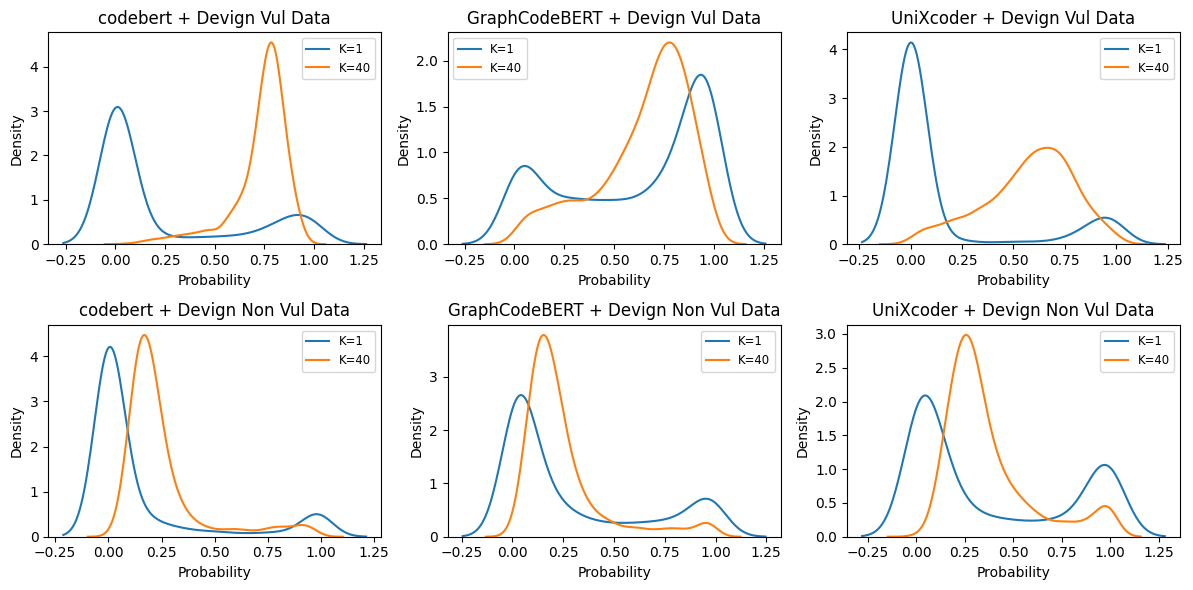

In [27]:
css = {
    'codebert': 'combine',
    'GraphCodeBERT':'combine',
    'UniXcoder': 'combine',
}
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axs=axs.flat
cnt = 0
for model  in ("codebert", "GraphCodeBERT", "UniXcoder"):
    cs = css[model]
    filename = get_file_name(model, dataset, cs)
    data = read_jsonl(f"../../data/{dataset}/{filename}.jsonl")

    vanilla_at_path = get_attribution_path(model, dataset, 'vanilla', filename)
    causal_at_path = get_attribution_path(model, dataset, get_causal_version(model, dataset, cs), filename, inference=True)
    
    vanilla_att = read_pkl(vanilla_at_path)
    causal_att = read_pkl(causal_at_path)
    # print(vanilla_att)
    df = pd.DataFrame()

    df['index'] = [ex['idx'] for ex in data]
    df['label'] = [ex['target'] for ex in data]
    df['vanilla_prob'] = [ex['pred'][-1] for ex in vanilla_att]
    df['deadcode_prob'] = [ex['pred'][1]  for ex in causal_att]
    # print(df['deadcode_prob'])
    df = df[df['label'] == 1]
    # sns.kdeplot(df['vanilla_prob'], ax=axs[cnt], label="Vanilla")
    sns.kdeplot(df['deadcode_prob'], ax=axs[cnt], label="K=1")

    vanilla_at_path = get_attribution_path(model, dataset, 'vanilla', filename)
    causal_at_path = get_attribution_path(model, dataset, get_causal_version(model, dataset, cs), filename)
    
    vanilla_att = read_pkl(vanilla_at_path)
    causal_att = read_pkl(causal_at_path)
    # print(vanilla_att)
    df = pd.DataFrame()

    df['index'] = [ex['idx'] for ex in data]
    df['label'] = [ex['target'] for ex in data]
    df['vanilla_prob'] = [ex['pred'][-1] for ex in vanilla_att]
    df['deadcode_prob'] = [ex['pred'][1] /40  for ex in causal_att]
    # print(df['deadcode_prob'])
    df = df[df['label'] == 1]
    # sns.kdeplot(df['vanilla_prob'], ax=axs[cnt], label="Vanilla")
    # sns.kdeplot(df['deadcode_prob'], ax=axs[cnt], label="Causal")
    # sns.kdeplot(df['vanilla_prob'], ax=axs[cnt], label="Vanilla")
    sns.kdeplot(df['deadcode_prob'], ax=axs[cnt], label="K=40",)


    model_d = model
    if model == 'codebert':
        model_d = "CodeBERT"
    axs[cnt].legend(fontsize='small')
    axs[cnt].title.set_text(f"{model} + {dataset} Vul Data")

    axs[cnt].set_xlabel("Probability")
    axs[cnt].set_ylabel("Density")
    cnt += 1

for model  in ("codebert", "GraphCodeBERT", "UniXcoder"):
    cs = css[model]
    filename = get_file_name(model, dataset, cs)
    data = read_jsonl(f"../../data/{dataset}/{filename}.jsonl")

    vanilla_at_path = get_attribution_path(model, dataset, 'vanilla', filename)
    causal_at_path = get_attribution_path(model, dataset, get_causal_version(model, dataset, cs), filename, inference=True)
    
    vanilla_att = read_pkl(vanilla_at_path)
    causal_att = read_pkl(causal_at_path)
    # print(vanilla_att)
    df = pd.DataFrame()

    df['index'] = [ex['idx'] for ex in data]
    df['label'] = [ex['target'] for ex in data]
    df['vanilla_prob'] = [1-ex['pred'][-1] for ex in vanilla_att]
    df['deadcode_prob'] = [ex['pred'][0]   for ex in causal_att]
    # print(df['deadcode_prob'])
    df = df[df['label'] == 0]
    # sns.kdeplot(df['vanilla_prob'], ax=axs[cnt], label="Vanilla")
    sns.kdeplot(df['deadcode_prob'], ax=axs[cnt], label="K=1")
    vanilla_at_path = get_attribution_path(model, dataset, 'vanilla', filename)
    causal_at_path = get_attribution_path(model, dataset, get_causal_version(model, dataset, cs), filename)
    
    vanilla_att = read_pkl(vanilla_at_path)
    causal_att = read_pkl(causal_at_path)
    # print(vanilla_att)
    df = pd.DataFrame()

    df['index'] = [ex['idx'] for ex in data]
    df['label'] = [ex['target'] for ex in data]
    df['vanilla_prob'] = [1-ex['pred'][-1] for ex in vanilla_att]
    df['deadcode_prob'] = [ex['pred'][0] /40 for ex in causal_att]
    # print(df['deadcode_prob'])
    df = df[df['label'] == 0]
    # sns.kdeplot(df['vanilla_prob'], ax=axs[cnt], label="Vanilla")
    # sns.kdeplot(df['deadcode_prob'], ax=axs[cnt], label="Causal")
    # sns.kdeplot(df['vanilla_prob'], ax=axs[cnt], label="Vanilla")
    sns.kdeplot(df['deadcode_prob'], ax=axs[cnt], label="K=40",)


    model_d = model
    if model == 'codebert':
        model_d = "CodeBERT"
    axs[cnt].legend(fontsize='small')
    axs[cnt].title.set_text(f"{model} + {dataset} Non Vul Data")

    axs[cnt].set_xlabel("Probability")
    axs[cnt].set_ylabel("Density")
    cnt += 1
          
        # w, p = wilcoxon(df['vanilla_prob'], df['deadcode_prob'], alternative='less')
        # p = cohens(df['deadcode_prob'].values, df['vanilla_prob'].values)
    #     p_values.append(p)
    # values.append(p_values)
plt.tight_layout()
plt.savefig("representation_density_combined_k_1_vs_40.pdf")